In [6]:
import pymech.neksuite as nek
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import scipy.spatial
from tqdm import tqdm

In [7]:
NEK_5000_DIRECTORY = "..\\"
FILE_HEADER = "Mesh01_3D0"
NUMBER_OF_OUTPUT_FILES = 150
EXPORTING_DIRECTORY = ""
res = res = pd.DataFrame({'Time':[],'K_H':[]})

In [8]:
def integration(data):
    ndim = data.ndim
    total = 0

    for e in tqdm(data.elem):
        npoints = e.temp.size
        # Reshape the array
        pos_rearranged = np.reshape(e.pos, (3,npoints))
        pos = pos_rearranged.T
        # Do the same thing for Velocity
        vel_rearranged = np.reshape(e.vel, (3,npoints))
        vel = vel_rearranged.T
        # Get the sum of velocity squares for each row (u^2+v^2+w^2)
        ssq = np.sum(vel**2, axis=1)
        # Reshape temp (rho) as well
        temp = np.reshape(e.temp, (npoints))
        # Get V using the formula:
        v = 0.5*np.multiply(temp, ssq)
        ## Combining to make a 3d array of x,y,V
        pts = np.concatenate((pos,np.reshape(v,(npoints,1))), axis=1)

        # Delaunay
        d=scipy.spatial.Delaunay(pts[:,:3])
        t = pts[d.vertices]
        # Tetrahedron vectors
        v1 = t[:,0,:3] - t[:,1,:3]
        v2 = t[:,0,:3] - t[:,2,:3]
        v3 = t[:,0,:3] - t[:,3,:3]
        # V1 x V2
        surf = np.cross(v1,v2)
        # Vol = |(V1 x V2).V3| / 6
        # The list comprehension will help return an array of corresponding volume for the tetrahedrons
        vol = np.array([np.dot(v3[i],surf[i]) for i in range(0,len(v3))]) / 6.0 
        # Take the average temp for each tetrahedron
        avg = t[:,:,3].mean(axis = 1)
        # By geometry approximation, the 4D volume will be retrieved using |V| x Temp
        vol4d = np.multiply(np.abs(vol),avg)

        total += vol4d.sum()
    return total

In [9]:
for i in np.linspace(0,NUMBER_OF_OUTPUT_FILES,10):
    data = nek.readnek(NEK_5000_DIRECTORY + FILE_HEADER + ".f%05d" % (i+1))
    k = integration(data)
    res.loc[i] = [0.1*i, k]

100%|██████████| 22410/22410 [03:15<00:00, 114.78it/s]
CRITICAL: I/O error (2): No such file or directory


AttributeError: 'int' object has no attribute 'ndim'

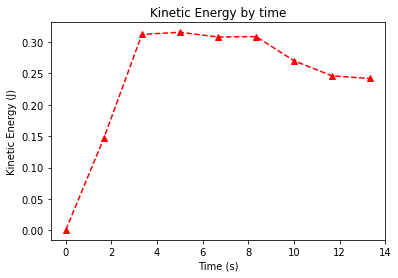

In [10]:
plt.plot(res['Time'], res['K_H'],'r^--')
plt.xlabel('Time (s)')
plt.ylabel('Kinetic Energy (J)')
plt.title('Kinetic Energy by time')
plt.savefig(EXPORTING_DIRECTORY + 'plot.png')
res.to_csv(EXPORTING_DIRECTORY + 'res.csv',index=False)